In [3]:
using BlossomV, LinearAlgebra, SparseArrays

┌ Info: Precompiling BlossomV [6c721016-9dae-5d90-abf6-67daaccb2332]
└ @ Base loading.jl:1278


In [4]:
# Implements algorithm 1 in Improved Algorithms for Detecting Negative Cost Cycles in Undirected Graphs.
# Xiaofeng Gu1, Kamesh Madduri, K. Subramani and Hong-Jian Lai

function optimal_cycle(G)
    G = sparse(G)
    rows,weights  = rowvals(G), nonzeros(G)
    ∂(i) = zip((@view rows[nzrange(G,i)]), (@view weights[nzrange(G,i)]))
    n=size(G,1);
    m=Int(length(rows)/2)
    E=Matching(Float64, 2n+2m)
    k = 2n+1
    edge(i,j,w) = add_edge(E, i-1, j-1, w)
    D=Dict{Int, Tuple{Int,Int}}()
    for i=1:n
        edge(i, i+n, 0)
        for (j,w) in ∂(i)
            if i < j
                edge(i,     k,   w)
                edge(i + n, k,   w)
                edge(j,     k+1, w)
                edge(j + n, k+1, w)
                edge(k,     k+1, 0)
                D[k]=(i,j)
                k+=2
            end
        end
    end
    @assert k == 2n+2m+1

    solve(E)

    sol=Tuple{Int,Int}[]
    for k=2n:2:2n+2m-1
        if get_match(E, k) != k + 1
            push!(sol, D[k+1])
        end
    end

    sol
end

optimal_cycle (generic function with 1 method)

In [67]:
#edge list, indices start at 0

G = [0  1  1  0  0 0;
     1  0 -3 -1  0 0;
     1 -3  0  0 -2 0;
     0 -1  0  0  0 0;
     0  0 -2  0  0 1;
     0  0  0  0  1 0]

@assert(issymmetric(G))

In [185]:
optimal_cycle(G)

8-element Array{Tuple{Int64,Int64},1}:
 (1, 13)
 (1, 14)
 (2, 7)
 (2, 11)
 (3, 7)
 (3, 11)
 (4, 13)
 (4, 14)

# Use it on a lossy compression instance

In [269]:
include("../code/headers.jl");

In [270]:
randseed = 1234
n = 10
m = 4
lm = LossyModel(2,n,m, randseed=randseed)
d = distortion(lm)
println("Distortion for the default solution (all zeros): ", d)

Distortion for the default solution (all zeros): 0.6


Compute optimal cycle

In [272]:
H = weighted_full_adjmat(lm)
op_ = optimal_cycle(H);

In [273]:
# Wizardry to go from edge numbering in the graph used to find cycles (1:m+n) 
#  to actual variable (1:n) and factor (1:m) indices
function variables_from_cycle(cy::Array{Tuple{Int64,Int64},1}, m::Int)
    cy_ = Array{Tuple{Int64,Int64},1}(undef, length(cy))
    for i in eachindex(cy)
        edge_as_vec = sort(collect(cy[i]))
        cy_[i] = (edge_as_vec[1], edge_as_vec[2]-m)
    end
    cy_    
end

variables_from_cycle (generic function with 2 methods)

In [274]:
op = variables_from_cycle(op_, m)

8-element Array{Tuple{Int64,Int64},1}:
 (1, 9)
 (1, 10)
 (2, 3)
 (2, 7)
 (3, 3)
 (3, 7)
 (4, 9)
 (4, 10)

Visualize the cycle(s)

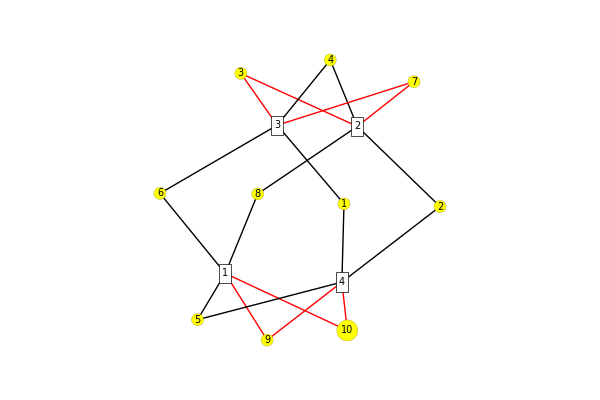

In [275]:
plot(lm.fg, highlighted_edges=op, randseed=randseed)

Flip the corresponding variables (__Warning__: do not run this cell twice otherwise the flip will cancel)

In [276]:
# Retrieve indices of variables to flip
to_flip = unique!([tup[2] for tup in op])
# Flip them in `lm.x` which is the internal state where the current solution guess is stored
lm.x[to_flip] .⊻= 1

4-element view(::Array{Int64,1}, [9, 10, 3, 7]) with eltype Int64:
 1
 1
 1
 1

Compute the distortion again

In [277]:
d2 = distortion(lm)
println("Distortion after flipping: ", d2)

Distortion after flipping: 0.2


Distortion decreased!

Try improving again

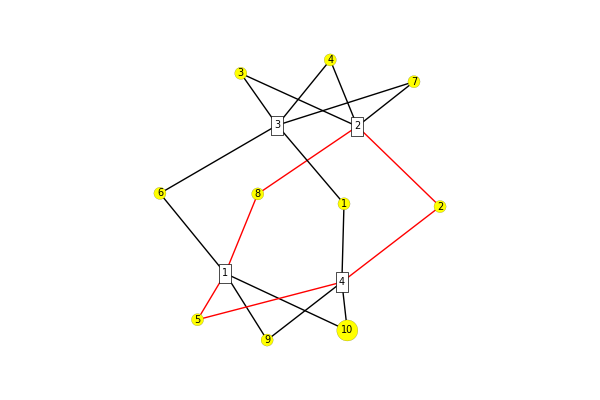

In [278]:
H = weighted_full_adjmat(lm)
op_ = optimal_cycle(H)
op = variables_from_cycle(op_, m)
plot(lm.fg, highlighted_edges=op, randseed=randseed)

In [279]:
to_flip = unique!([tup[2] for tup in op])
lm.x[to_flip] .⊻= 1
d3 = distortion(lm)
println("Distortion after flipping: ", d3)

Distortion after flipping: 0.1


Decreased again!

Try one last time

In [280]:
H = weighted_full_adjmat(lm)
op_ = optimal_cycle(H)

Tuple{Int64,Int64}[]

Solution is already optimal. Print it and compare it with the one obtained by exhaustive enumeration

In [281]:
x_cycles = lm.x

lm2 = deepcopy(lm)
solve!(lm2, ExhaustEnum())
x_exact = lm2.x
[x_cycles x_exact]

10×2 Array{Int64,2}:
 0  0
 1  1
 1  1
 0  0
 1  1
 0  0
 1  1
 1  1
 1  1
 1  1

Yes!

# On a larger instance

In [282]:
function one_loop_flip(lm::LossyModel)
    H = weighted_full_adjmat(lm)
    op = variables_from_cycle(optimal_cycle(H), lm.fg.m)
    to_flip = unique!([tup[2] for tup in op])
    lm.x[to_flip] .⊻= 1
    return op, to_flip, distortion(lm)
end

one_loop_flip (generic function with 1 method)

In [293]:
n = 100
m = 50
lm = LossyModel(2,n,m,randseed=randseed)
lm_copy = deepcopy(lm)

Lossy compression model:
 - Factor Graph with n=100 variables and m=50 factors defined on GF(2)
 - Inverse temperatures β₁=Inf for checks and β₂=1.0 for overlap


In [294]:
dist = Float64[]
finished = false
while !finished
    op,to_flip, d = one_loop_flip(lm)
    push!(dist, d)
    println("Iter ", length(dist), ". Distortion ", round(d, digits=4))
    finished = isempty(op)
end
println("Finished")
dist_cycles = distortion(lm)

Iter 1. Distortion 0.21
Iter 2. Distortion 0.13
Iter 3. Distortion 0.13
Finished


0.13

Compare with MS

In [295]:
ms = MS(maxiter=200)
res = solve!(lm_copy, ms)
dist_ms = distortion(lm_copy)

0.13